# MVA - Homework 1 - Reinforcement Learning (2021/2022)

**Name:** DERVISHI Megi

**Email:** megi.dervishi@ens.fr

## Instructions

* The deadline is **November 12 at 11:59 pm (Paris time).**

* By doing this homework you agree to the late day policy, collaboration and misconduct rules reported on [Piazza](https://piazza.com/class/ktmvsc4knke4ia?cid=6).

* **Mysterious or unsupported answers will not receive full credit**. A correct answer, unsupported by calculations, explanation, or algebraic work will receive no credit; an incorrect answer supported by substantially correct calculations and explanations might still receive partial credit.

* Answers should be provided in **English**.

# Colab setup

In [1]:
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
  # install rlberry library
  !pip install git+https://github.com/rlberry-py/rlberry.git@mva2021#egg=rlberry[default] > /dev/null 2>&1

  # install ffmpeg-python for saving videos
  !pip install ffmpeg-python > /dev/null 2>&1

  # packages required to show video
  !pip install pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

  print("Libraries installed, please restart the runtime!")


Libraries installed, please restart the runtime!


In [1]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# Initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

In [2]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt

# Preparation

In the coding exercises, you will use a *grid-world* MDP, which is represented in Python using the interface provided by the [Gym](https://gym.openai.com/) library. The cells below show how to interact with this MDP and how to visualize it.


In [3]:
from rlberry.envs import GridWorld

def get_env():
  """Creates an instance of a grid-world MDP."""
  env = GridWorld(
      nrows=5,
      ncols=7,
      reward_at = {(0, 6):1.0},
      walls=((0, 4), (1, 4), (2, 4), (3, 4)),
      success_probability=0.9,
      terminal_states=((0, 6),)
  )
  return env

def render_policy(env, policy=None, horizon=50):
  """Visualize a policy in an environment

  Args:
    env: GridWorld
        environment where to run the policy
    policy: np.array
        matrix mapping states to action (Ns).
        If None, runs random policy.
    horizon: int
        maximum number of timesteps in the environment.
  """
  env.enable_rendering()
  state = env.reset()                       # get initial state
  for timestep in range(horizon):
      if policy is None:
        action = env.action_space.sample()  # take random actions
      else:
        action = policy[state]
      next_state, reward, is_terminal, info = env.step(action)
      state = next_state
      if is_terminal:
        break
  # save video and clear buffer
  env.save_video('./videos/gw.mp4', framerate=5)
  env.clear_render_buffer()
  env.disable_rendering()
  # show video
  show_video('./videos/gw.mp4')


[INFO] OpenGL_accelerate module loaded 
[INFO] Using accelerated ArrayDatatype 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt 


In [4]:
# Create an environment and visualize it
env = get_env()
render_policy(env)  # visualize random policy

# The reward function and transition probabilities can be accessed through
# the R and P attributes:
print(f"Shape of the reward array = (S, A) = {env.R.shape}")
print(f"Shape of the transition array = (S, A, S) = {env.P.shape}")
print(f"Reward at (s, a) = (1, 0): {env.R[1, 0]}")
print(f"Prob[s\'=2 | s=1, a=0]: {env.P[1, 0, 2]}")
print(f"Number of states and actions: {env.Ns}, {env.Na}")

# The states in the griworld correspond to (row, col) coordinates.
# The environment provides a mapping between (row, col) and the index of
# each state:
print(f"Index of state (1, 0): {env.coord2index[(1, 0)]}")
print(f"Coordinates of state 5: {env.index2coord[5]}")

Shape of the reward array = (S, A) = (31, 4)
Shape of the transition array = (S, A, S) = (31, 4, 31)
Reward at (s, a) = (1, 0): 0.0
Prob[s'=2 | s=1, a=0]: 0.04999999999999999
Number of states and actions: 31, 4
Index of state (1, 0): 6
Coordinates of state 5: (0, 6)


# Part 1 - Dynamic Programming

## Question 1.1

Consider a general MDP with a discount factor of $\gamma < 1$. Assume that the horizon is infinite (so there is no termination). A policy $\pi$ in this MDP
induces a value function $V^\pi$. Suppose an affine transformation is applied to the reward, what is
the new value function? Is the optimal policy preserved?



### **Answer**

By definition let: $V^{\pi} = \mathbb{E}[\sum^\infty_{t=0} \gamma^tr(s_t,d_t(h_t)) | s_0=s;\pi]$.

Suppose an affine transformation is applied to the reward $r$ which results to a new reward $r'$. Then:
$$r'(s_t +d_t(h_t)) = ar(s_t,d_t(h_t))+b$$ where $a \neq 0$ (otherwise we would have 0 reward and hence it is trivial), and $b \in \mathbb{R}$.
The new induced value function would hence be:
\begin{align}
V^{\pi'} &=  \mathbb{E}[\sum^\infty_{t=0} \gamma^tr'(s_t,d_t(h_t)) | s_0=s;\pi']\\ 
&= \mathbb{E}[\sum^\infty_{t=0} \gamma^t(ar(s_t,d_t(h_t))+b) | s_0=s;\pi']\\
&= \mathbb{E}[\sum^\infty_{t=0} \gamma^tar(s_t,d_t(h_t)) | s_0=s;\pi'] + \mathbb{E}[\sum^\infty_{t=0} \gamma^tb | s_0=s;\pi']
\end{align}
Since $\mathbb{E}[\sum^\infty_{t=0} \gamma^tb | s_0=s;\pi']$ is not a random variable then it is equal to $\sum^\infty_{t=0} \gamma^tb = \frac{b}{1-\gamma}$ which is a constant that we can denote as $b'$.
Therefore we have:
\begin{align}
V^{{\pi'}}(s) &= a\mathbb{E}[\sum^\infty_{t=0} \gamma^tr(s_t,d_t(h_t)) | s_0=s;\pi'] + b'
\end{align}
Now adding a constant $b'$ will not change the argmax, however we now have to distinguish two cases. Given a function $f$ if $a > 0$ then $\arg\max_x a f(x) = \arg\max f(x)$, hence we see that if $a > 0$ then the optimal policy will be left invariant. However if $a < 0$ then we have that $\arg\max_x a f(x) = \arg\min_x f(x)$ hence the optimal policy will change.



## Question 1.2

Consider an infinite-horizon $\gamma$-discounted MDP. We denote by $Q^*$ the $Q$-function of the optimal policy $\pi^*$. Prove that, for any function $Q(s, a)$ (which is **not** necessarily the value function of a policy), the following inequality holds for any state $s$:

$$
V^{\pi_Q}(s) \geq V^*(s) - \frac{2}{1-\gamma}||Q^*-Q||_\infty,
$$

where $||Q^*-Q||_\infty = \max_{s, a} |Q^*(s, a) - Q(s, a)|$ and $\pi_Q(s) \in \arg\max_a Q(s, a)$. Can you use this result to show that any policy $\pi$ such that $\pi(s) \in \arg\max_a Q^*(s, a)$ is optimal?

### **Answer**

Let $a \in \mathcal{A}$, we have:
\begin{align}
\|V^* - V^{\pi_Q}\| &= \|V^* - Q(\cdot,a) + Q(\cdot,a)- V^{\pi_Q}\| \\
&\leq \|V^* - Q(\cdot,a)\| + \|Q(\cdot,a) - V^{\pi_Q}\| \\
&= \|V^* - Q(\cdot,a)\| + \|Q(\cdot,a) - V^* + V^* - V^{\pi_Q}\|\\
&\leq \|V^* - Q(\cdot,a)\| + \|Q(\cdot,a) - V^*(s)\| + \|V^* - V^{\pi_Q}\|\\
&\leq 2\|V^* - Q(\cdot,a)\| + \|\mathcal{T}^{*} V^* - \mathcal{T}^{*} V^{\pi_Q}\|
\end{align}
Now using that the Bellman operators are a $\gamma$ contraction of the $\infty$ norm we can rewrite the above as 
\begin{align}
\forall a \in \mathcal{A}, \forall s \in \mathcal{S}, \quad (1 - \gamma) \|V^* - V^{\pi_Q}\| &\leq 2\|V^* - Q(\cdot,a)\|\\
\Leftrightarrow \|V^* - V^{\pi_Q}\| &\leq \frac{2}{1 - \gamma} \|V^* - Q(\cdot,a)\|
\end{align}
Now note the two following identities
\begin{equation}
V^* = \max_a Q^*(\cdot, a) \quad \text{and} \quad \pi_Q(s) \in \arg\max_a Q(s, a) \Rightarrow Q(s, \pi_Q(s)) = \max_a Q(s, a)   
\end{equation}
Now take the previous inequality, set $s^* = \arg\max_s |V^*(s) - Q(s, \pi_Q(s))|$ then take $a = \pi_Q(s^*)$, which leads to
\begin{align}
\|V^* - V^{\pi_Q}\| &\leq \frac{2}{1 - \gamma} |\max_a Q^*(s^*, a) - \max_a Q(s^*,a)|\\
&\leq \frac{2}{1 - \gamma} \max_a | Q^*(s^*, a) - Q(s^*, a)|\\
&\leq \frac{2}{1 - \gamma} \max_{a, s} | Q^*(s, a) - Q(s, a)|\\
&\leq \frac{2}{1 - \gamma} \| Q^* - Q\|
\end{align}
Hence we obtain that
\begin{equation}
V^* - V^{\pi_Q} \leq \|V^* - V^{\pi_Q}\| \leq \frac{2}{1- \gamma} \|Q^* - Q\|.
\end{equation}
QED.

Yes this result can be used to show that any policy $\pi(s) \in \arg\max_a Q^*(s, a)$ is optimal. Indeed fix $\pi(s) \in \arg\max_a Q^*(s, a)$, take the inequality and let $Q = Q^*$. Then we have that $\pi_Q = \pi$ and the inequality becomes
\begin{equation}
V^{\pi} = V^{\pi_Q} \geq V^*
\end{equation}
However from the definition of $V^*$ we know that $V^*$ must be maximal. Hence $V^\pi = V^*$ and $\pi$ is an optimal policy.


## Question 1.3

In this question, you will implement and compare the policy and value iteration algorithms for a finite MDP. 

Complete the functions `policy_evaluation`, `policy_iteration` and `value_iteration` below.


Compare value iteration and policy iteration. Highlight pros and cons of each method.

### **Answer**

[pros/cons of each method + implementation below]

As we have seen from the lecture the advantage of value iteration is that each iteration is very computationally efficient since we are performing only a single matrix multiplication. However a drawback is that we converge only asymptotically to the result. Policy evaluation on the other hand will converge in a finite number of iterations. However each iteration requires a full policy evaluation (i.e. the inversion of a matrix) which is computationally expensive.

In [97]:
def policy_evaluation(P, R, policy, gamma=0.9, tol=1e-2):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        policy: np.array
            matrix mapping states to action (Ns)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        value_function: np.array
            The value function of the given policy
    """
    Ns, Na = R.shape
    R_policy = np.array([R[i, policy[i]] for i in range(Ns)])
    P_policy = np.array([P[i, policy[i],:] for i in range(Ns)])
    value_function = np.linalg.solve((np.identity(Ns) - gamma * P_policy), R_policy)
    return value_function

In [98]:
def policy_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        policy: np.array
            the final policy
        V: np.array
            the value function associated to the final policy
    """
    Ns, Na = R.shape
    V = np.zeros(Ns)
    policy = np.ones(Ns, dtype=np.int)
    value_change = np.inf
    
    while value_change >= tol:
        new_value_function = policy_evaluation(P, R, policy, gamma = gamma)
        value_change = np.max(np.abs(new_value_function - V))
        V = np.copy(new_value_function)
        improved_policy = np.argmax(R + gamma * P @ V, axis = 1)
        policy = improved_policy

    return policy, V

In [99]:
def value_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        Q: final Q-function (at iteration n)
        greedy_policy: greedy policy wrt Qn
        Qfs: all Q-functions generated by the algorithm (for visualization)
    """
    Ns, Na = R.shape
    Q = np.zeros((Ns, Na))
    Qfs = [Q]
	  
    Q_change = np.inf
    while Q_change >= tol:
      new_Q = R + gamma * (P @ np.max(Q, axis = 1))
      Q_change = np.max(np.max(np.abs(new_Q - Q), axis = 1), axis = 0)
      Q = new_Q
      Qfs.append(Q)

    greedy_policy = np.argmax(Q, axis=1)
    return Q, greedy_policy, Qfs

### Testing your code

[VI]Greedy policy: 



[PI]final policy: 


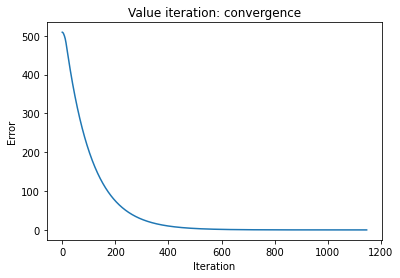

In [101]:
# Parameters
tol = 1e-5
gamma = 0.99

# Environment
env = get_env()

# run value iteration to obtain Q-values
VI_Q, VI_greedypol, all_qfunctions = value_iteration(env.P, env.R, gamma=gamma, tol=tol)

# render the policy
print("[VI]Greedy policy: ")
render_policy(env, VI_greedypol)

# compute the value function of the greedy policy using matrix inversion
# ====================================================

greedy_V = policy_evaluation(env.P, env.R, VI_greedypol, gamma=gamma)

# ====================================================

# show the error between the computed V-functions and the final V-function
# (that should be the optimal one, if correctly implemented)
# as a function of time
final_V = all_qfunctions[-1].max(axis=1)
norms = [ np.linalg.norm(q.max(axis=1) - final_V) for q in all_qfunctions]
plt.plot(norms)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Value iteration: convergence")

#### POLICY ITERATION ####
PI_policy, PI_V = policy_iteration(env.P, env.R, gamma=gamma, tol=tol)

print("\n[PI]final policy: ")
render_policy(env, PI_policy)

plt.show()
## Uncomment below to check that everything is correct
#print(PI_policy, VI_greedypol)
#print(PI_V, greedy_V)
assert np.allclose(PI_policy, VI_greedypol),\
     "You should check the code, the greedy policy computed by VI is not equal to the solution of PI"
assert np.allclose(PI_V, greedy_V),\
     "Since the policies are equal, even the value function should be"

plt.show()

# Part 2 - Tabular RL

## Question 2.1

The code below collects two datasets of transitions (containing states, actions, rewards and next states) for a discrete MDP.

For each of the datasets:

1. Estimate the transitions and rewards, $\hat{P}$ and $\hat{R}$.
2. Compute the optimal value function and the optimal policy with respect to the estimated MDP (defined by $\hat{P}$ and $\hat{R}$), which we denote by $\hat{\pi}$ and $\hat{V}$.
3. Numerically compare the performance of $\hat{\pi}$ and $\pi^\star$ (the true optimal policy), and the error between $\hat{V}$ and $V^*$ (the true optimal value function).

Which of the two data collection methods do you think is better? Why?

### **Answer**

I think the first data collection method is better because the samples are all related while in the second data collection method the samples are taken randomly and hence some samples may not help us in learning the target policy. In other words, the first data collection will have a better sample efficicency as I describe later in question 2.3. Indeed in most cases we observe that the performance of the estimated policy for the first dataset is higher than the one of the second dataset. Similary the errors are also usually better for the first dataset altough there is a bigger variance.


In [102]:
def estimate_PR(dataset):
    """ Estimate P and R from a given dataset. """
    s, a, r, ns = dataset
    S = list(set(s).union(set(ns)))
    Ns = len(S)
    A = list(set(a))
    Na = len(A)
    Nsas = dict()
    Nsa = dict()
    for i in range(len(s)):
        if (s[i], a[i], ns[i]) not in Nsas.keys():
            Nsas[s[i], a[i], ns[i]] = 0
        Nsas[s[i], a[i], ns[i]] += 1
        if (s[i], a[i]) not in Nsa.keys():
            Nsa[s[i], a[i]] = 0
        Nsa[s[i], a[i]] += 1
    P = np.zeros((Ns, Na, Ns))
    R = np.zeros((Ns, Na))
    for (si, ai, nsi), cnt in Nsas.items():
        P[S.index(si), A.index(ai), S.index(nsi)] = Nsas[si, ai, nsi]/Nsa[si, ai]
        R[S.index(si), A.index(ai)] = 1/Nsa[si, ai] * np.sum(r[(si == s)*(ai == a)])
    return P, R


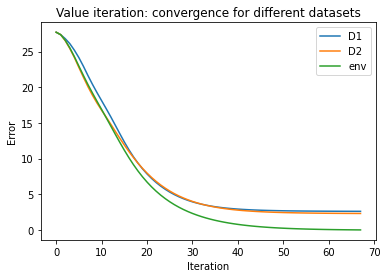

Performance of the estimated pi from dataset 1 3.5872535190472674
Performance of the estimated pi from dataset 2 4.234860608446979


In [89]:
def get_random_policy_dataset(env, n_samples):
  """Get a dataset following a random policy to collect data."""
  states = []
  actions = []
  rewards = []
  next_states = []
  
  state = env.reset()
  for _ in range(n_samples):
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.step(action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    # update state
    state = next_state
    if is_terminal:
      state = env.reset()

  dataset = (np.array(states), np.array(actions), np.array(rewards), np.array(next_states))
  return dataset

def get_uniform_dataset(env, n_samples):
  """Get a dataset by uniformly sampling states and actions."""
  states = []
  actions = []
  rewards = []
  next_states = []
  for _ in range(n_samples):
    state = env.observation_space.sample()
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.sample(state, action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)

  dataset = (np.array(states), np.array(actions), np.array(rewards), np.array(next_states))
  return dataset

while True:
    # If the datasets sampled in P1, R1 or P2, R2 are incomplete then the trained model
    # will be missing some rows/cols hence the following comparison won't work.

    
    # Collect two different datasets
    num_samples = 500
    env = get_env()
    dataset_1 = get_random_policy_dataset(env, num_samples)
    dataset_2 = get_uniform_dataset(env, num_samples)

    # Item 3: Estimate the MDP with the two datasets; compare the optimal value
    # functions in the true and in the estimated MDPs

    P1, R1 = estimate_PR(dataset_1)
    P2, R2 = estimate_PR(dataset_2)

    Q1, greedy_policy1, Qfs1 = value_iteration(P1, R1)
    Q2, greedy_policy2, Qfs2 = value_iteration(P2, R2)
    Q3, greedy_policy3, Qfs3 = value_iteration(env.P, env.R)

    final_V3 = Qfs3[-1].max(axis=1)
    norms3 = [ np.linalg.norm(q.max(axis=1) - final_V3) for q in Qfs3]
    final_V1 = Qfs1[-1].max(axis=1)
    if final_V1.shape == final_V3.shape and final_V2.shape == final_V3.shape:
        break

norms1 = [ np.linalg.norm(q.max(axis=1) - final_V3) for q in Qfs1]
plt.plot(norms1, label = 'D1')

final_V2 = Qfs2[-1].max(axis=1)
norms2 = [ np.linalg.norm(q.max(axis=1) - final_V3) for q in Qfs2]
plt.plot(norms2, label = 'D2')

plt.plot(norms3, label = 'env')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Value iteration: convergence for different datasets")
plt.show()

#print(np.linalg.norm(final_V1 - final_V3), np.linalg.norm(final_V2 - final_V3))
policy_performance1 = np.mean(policy_evaluation(env.P, env.R, greedy_policy1))
policy_performance2 = np.mean(policy_evaluation(env.P, env.R, greedy_policy2))
print('Performance of the estimated pi from dataset 1', policy_performance1)
print('Performance of the estimated pi from dataset 2', policy_performance2)

## Question 2.2

Suppose that $\hat{P}$ and $\hat{R}$ are estimated from a dataset of exactly $N$ i.i.d. samples from **each** state-action pair. This means that, for each $(s,a)$, we have $N$ samples $\{(s_1',r_1, \dots, s_N', r_N\}$, where $s_i' \sim P(\cdot | s,a)$ and $r_i \sim R(s,a)$ for $i=1,\dots,N$, and
$$ \hat{P}(s'|s,a) = \frac{1}{N}\sum_{i=1}^N \mathbb{1}(s_i' = s'), $$
$$ \hat{R}(s,a) = \frac{1}{N}\sum_{i=1}^N r_i.$$
Suppose that $R$ is a distribution with support in $[0,1]$. Let $\hat{V}$ be the optimal value function computed in the empirical MDP (i.e., the one with transitions $\hat{P}$ and rewards $\hat{R}$). For any $\delta\in(0,1)$, derive an upper bound to the error

$$ \| \hat{V} - V^* \|_\infty $$

which holds with probability at least $1-\delta$.

**Note** Your bound should only depend on deterministic quantities like $N$, $\gamma$, $\delta$, $S$, $A$. It should *not* dependent on the actual random samples.

**Hint** The following two inequalities may be helpful.

1. **A (simplified) simulation lemma**. For any state $\bar{s}$,

$$ |\hat{V}(\bar{s}) - V^*(\bar{s})| \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$$

2. **Hoeffding's inequality**. Let $X_1, \dots X_N$ be $N$ i.i.d. random variables bounded in the interval $[0,b]$ for some $b>0$. Let $\bar{X} = \frac{1}{N}\sum_{i=1}^N X_i$ be the empirical mean. Then, for any $\epsilon > 0$,

$$ \mathbb{P}(|\bar{X} - \mathbb{E}[\bar{X}]| > \epsilon) \leq 2e^{-\frac{2N\epsilon^2}{b^2}}.$$

### **Answer**

Before we start note that by an abuse of notation $R(s,a)$ in the simplified simulation lemma is actually $\mathbb{E}[R(s,a)]$.

We have that: $\|\hat{V} - V^*\|_\infty = \max_{\bar{s}}|\hat{V}(\bar{s}) - V^*(\bar{s})|$. We can then apply the first simulation lemma and get: 

\begin{align}
\\\|\hat{V} - V^*\|_\infty &\leq \frac{1}{1-\gamma}\max_{s,a} \left|\mathbb{E}[R(s,a)] - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|\\
&= \frac{1}{1-\gamma}\max_{s,a} \left| \mathbb{E}[R(s,a)] - \hat{R}(s,a) + \gamma \sum_{s'}P(s'|s,a)V^*(s') - \gamma \sum_{s'}\hat{P}(s'|s,a) V^*(s') \right|\\
&\leq \frac{1}{1-\gamma}\max_{s,a} \left|\mathbb{E}[R(s,a)] - \hat{R}(s,a) + \gamma \mathbb{E}[V^*(s')]_{s'\sim P(\cdot|s,a)} - \gamma \sum_{s'}\hat{P}(s'|s,a) V^*(s') \right|
\end{align}
We then observe that:
$$\sum_{s'}\hat{P}(s'|s,a) V^*(s') = \frac{1}{N}\sum_{s'}\sum_{i=1}^N \mathbb{1}_{(s'_i=s')}V^*(s') = \frac{1}{N}\sum_{i=1}^NV^*(s'_i)$$ The two sums simplify as the only non-zero terms would be those whose $s' = s'_i$. We re-input this result in the previous inequality and get:
\begin{align}
&= \frac{1}{1-\gamma}\max_{s,a} \left|\mathbb{E}[R(s,a)] - \hat{R}(s,a) + \gamma \mathbb{E}[V^*(s')]_{s'\sim P(\cdot|s,a)} - \frac{\gamma}{N}\sum_{i=1}^NV^*(s'_i) \right|\\
&= \frac{1}{1-\gamma}\max_{s,a} \left|\mathbb{E}[R(s,a) + \gamma V^*(s')]_{s'\sim P(\cdot|s,a)} - \hat{R}(s,a)  - \frac{\gamma}{N}\sum_{i=1}^NV^*(s'_i) \right|\\
&\leq \frac{1}{1-\gamma}\frac{1}{N}\sum_i \left|\mathbb{E}[R(s_i,a_i) + \gamma V^*(s')]_{s'\sim P(\cdot|s_i,a_i)} - \hat{R}(s_i,a_i) - \frac{\gamma}{N}\sum_{j=1}^NV^*(s'_j)  \right| \tag{1}
\end{align}

Let $\bar{X_i}$ be an i.i.d random variable such that: $$\bar{X_i}= \hat{R}(s_i,a_i) + \frac{\gamma}{N}\sum_{j=1}^NV^*(s'_j)$$ then equation (1) would be equal to: $$\frac{1}{1-\gamma}\frac{1}{N} \sum_{i} \left| \mathbb{E}[\bar{X_i}] - \bar{X_i} \right|$$

We can now calculate $\mathbb{P}[\|\hat{V} - V^*\|_{\infty} > ɛ]$ for any $ɛ>0$: 
\begin{align}
\mathbb{P}[\|\hat{V} - V^*\|_{\infty} > ɛ] \leq \frac{1}{1-\gamma}\frac{1}{N} \sum_{i} \mathbb{P}\left[\left|\mathbb{E}[\bar{X_i}] - \bar{X_i} \right| > ɛ\right]
\tag{2}
\end{align}
Since $\bar{X_i}$ are i.i.d then for all $i$, $\mathbb{P}[\bar{X_i}] = \mathbb{P}[\bar{X_0}]$. Hence (2) becomes (3) at which point we apply the Hoeffding's inequality to get the bound (4)
\begin{align}
\mathbb{P}[\|\hat{V} - V^*\|_{\infty} > ɛ] \leq \frac{1}{1-\gamma}\frac{1}{N} N \mathbb{P}\left[\left|\mathbb{E}[\bar{X_0}] - \bar{X_0} \right| > ɛ\right] \tag{3}\\
\mathbb{P}[\|\hat{V} - V^*\|_{\infty} > ɛ] \leq \frac{1}{1-\gamma} 2e^{-\frac{2N\varepsilon^2}{b^2}}\tag{4}
\end{align}
Now let us compute exactly $b$ and $\varepsilon$. We defined $b$ as the range of $\bar{X}$ then we are told that $R \in [0, 1]$ hence we only have to compute the bound on $V^*$. 
\begin{equation}
V^* = \mathbb{E}[\sum_t \gamma^t r(s, \pi^*(s)) ] \in \left[0, \frac{1}{1 - \gamma}\right]
\end{equation}
Hence we get that
\begin{equation}
b = 1 + \frac{\gamma}{1 - \gamma} = \frac{1}{1 - \gamma}
\end{equation}
Hence if we want an upper bound that holds with probability at least $1 - \delta$ we have to find $\varepsilon$ such that
\begin{equation}
\delta = \frac{2}{1 - \gamma} e^{-2 N \varepsilon^2(1 - \gamma)^2} \Rightarrow \varepsilon = \sqrt{\frac{\log\left(\frac{2}{\delta(1 - \gamma)}\right)}{2 N (1 - \gamma)^2}}
\end{equation} 


## Question 2.3

Suppose once again that we are given a dataset of $N$ samples in the form of tuples $(s_i,a_i,s_i',r_i)$. We know that each tuple contains a valid transition from the true MDP, i.e., $s_i' \sim P(\cdot | s_i, a_i)$ and $r_i \sim R(s_i,a_i)$, while the state-action pairs $(s_i,a_i)$ from which the transition started can be arbitrary.

Suppose we want to apply Q-learning to this MDP. Can you think of a way to leverage this offline data to improve the sample-efficiency of the algorithm? What if we were using SARSA instead?

### **Answer**

Q-learning is an off-policy learning and as such needs to learn the target policy based on arbitrary samples. However it can be that certain samples are not as important as others. Hence in order to improve sampling-efficiency we have to filter the samples that are related to the target policy. One way to do so is using importance sampling.

On the other hand SARSA is an on-policy learning and hence we cannot adapt the samples on which it trains.


# Part 3 - RL with Function Approximation

## Question 3.1

Given a datset $(s_i, a_i, r_i, s_i')$ of (states, actions, rewards, next states), the Fitted Q-Iteration (FQI) algorithm proceeds as follows:


* We start from a $Q$ function $Q_0 \in \mathcal{F}$, where $\mathcal{F}$ is a function space;
* At every iteration $k$, we compute $Q_{k+1}$ as:

$$
Q_{k+1}\in\arg\min_{f\in\mathcal{F}} \frac{1}{2}\sum_{i=1}^N
\left(
  f(s_i, a_i) - y_i^k
\right)^2 + \lambda \Omega(f)
$$
where $y_i^k = r_i + \gamma \max_{a'}Q_k(s_i', a')$, $\Omega(f)$ is a regularization term and $\lambda > 0$ is the regularization coefficient.


Consider FQI with *linear* function approximation. That is, for a given feature map $\phi : S \rightarrow \mathbb{R}^d$, we consider a parametric family of $Q$ functions $Q_\theta(s,a) = \phi(s)^T\theta_a$ for $\theta_a\in\mathbb{R}^d$. Suppose we are applying FQI on a given dataset of $N$ tuples of the form $(s_i, a_i, r_i, s_i')$ and we are at the $k$-th iteration. Let $\theta_k \in\mathbb{R}^{d \times A}$ be our current parameter. Derive the *closed-form* update to find $\theta_{k+1}$, using $\frac{1}{2}\sum_a ||\theta_a||_2^2$ as regularization.

### **Answer**

Let us clarify certain notations. By definition $f(s,a) = \phi(s)^T\theta_a$ and $\Omega(f) = \frac{1}{2} \sum_a \|\theta_a\|_2^2$. The problem then transforms to minimizing the $\mathcal{L}$ function defined below w.t.r to $\theta_a$ for any $a$.
\begin{align}
\mathcal{L} &=  \frac{1}{2}\sum_{i=1}^N(\phi(s_i)^T\theta_{a_i} - y_i^k)^2 + λ\frac{1}{2}\sum_{a}\|\theta_a\|_2^2
\end{align}
We compute the $\nabla_{\theta_a} \mathcal{L} = 0$.
\begin{align}
\nabla_{\theta_a} \mathcal{L} &= \frac{1}{2} \sum_{i=1, \,a_i=a} 2(\phi(s_i)^T\theta_a - y_i^k)\phi(s_i)^T + \lambda\frac{1}{2}2\theta_a^T\\
0 &=  \sum_{i=1, \,a_i=a} (\phi(s_i)^T\theta_a\phi(s_i)^T - y_i^k\phi(s_i)^T) + \lambda\theta_a^T\\
\end{align}
Now notice that $\phi(s_i)^T \theta_a$ is a scalar and hence $\phi(s_i)^T \theta_a = \theta_a^T \phi(s_i)$ which when we replace it in the previous equation we get 
\begin{align}
0 &= \sum_{i=1, \,a_i=a} \theta_a^T\phi(s_i)\phi(s_i)^T - \sum_{i=1, \,a_i=a}y_i^k\phi(s_i)^T + \lambda\theta_a^T\\
\sum_{i=1, \,a_i=a}y_i^k\phi(s_i)^T &= \sum_{i=1, \,a_i=a} \theta_a^T\phi(s_i)\phi(s_i)^T + \lambda\theta_a^T\\
\sum_{i=1, \,a_i=a}y_i^k\phi(s_i)^T &= \theta_a^T(\sum_{i=1, \,a_i=a} \phi(s_i)\phi(s_i)^T + \lambda I_d)
\end{align} 
We can take the transpose of the expression to have nicer results, and obtain the closed form for $\theta_a$:
\begin{align}
\sum_{i=1, \,a_i=a}y_i^k\phi(s_i) &= \left(\sum_{i=1, \,a_i=a} \phi(s_i)\phi(s_i)^T + \lambda I_d\right)\theta_a\\
\theta_a &= \left(\sum_{i=1, \,a_i=a} \phi(s_i)\phi(s_i)^T + \lambda I_d\right)^{-1}\sum_{i=1, \,a_i=a}y_i^k\phi(s_i)
\end{align}
Hence we can find all $\theta_a \in \theta_{k+1}$ as a function of the $\theta'_a \in \theta_k$ which are hidden in $y_i^k$.

## Question 3.2

The code below creates a larger gridworld (with more states than the one used in the previous questions), and defines a feature map. Implement linear FQI to this environment (in the function `linear_fqi()` below), and compare the approximated $Q$ function to the optimal $Q$ function computed with value iteration.

Can you improve the feature map in order to reduce the approximation error?

### **Answer**

I tried to reduce the approximation error by augmenting the dimensions of the function space and also augmenting the penalty term.

In [103]:
def get_large_gridworld():
  """Creates an instance of a grid-world MDP with more states."""
  walls = [(ii, 10) for ii in range(15) if (ii != 7 and ii != 8)]
  env = GridWorld(
      nrows=15,
      ncols=15,
      reward_at = {(14, 14):1.0},
      walls=tuple(walls),
      success_probability=0.9,
      terminal_states=((14, 14),)
  )
  return env


class GridWorldFeatureMap:
  """Create features for state-action pairs
  
  Args:
    dim: int
      Feature dimension
    sigma: float
      RBF kernel bandwidth
  """
  def __init__(self, env, dim=15, sigma=0.25):
    self.index2coord = env.index2coord
    self.n_states = env.Ns
    self.n_actions = env.Na
    self.dim = dim
    self.sigma = sigma

    n_rows = env.nrows
    n_cols = env.ncols

    # build similarity matrix
    sim_matrix = np.zeros((self.n_states, self.n_states))
    for ii in range(self.n_states):
        row_ii, col_ii = self.index2coord[ii]
        x_ii = row_ii / n_rows
        y_ii = col_ii / n_cols
        for jj in range(self.n_states):
            row_jj, col_jj = self.index2coord[jj]
            x_jj = row_jj / n_rows
            y_jj = col_jj / n_cols
            dist = np.sqrt((x_jj - x_ii) ** 2.0 + (y_jj - y_ii) ** 2.0)
            sim_matrix[ii, jj] = np.exp(-(dist / sigma) ** 2.0)

    # factorize similarity matrix to obtain features
    uu, ss, vh = np.linalg.svd(sim_matrix, hermitian=True)
    self.feats = vh[:dim, :]

  def map(self, observation):
    feat = self.feats[:, observation].copy()
    return feat

In [104]:
env = get_large_gridworld()
feat_map = GridWorldFeatureMap(env)

# Visualize large gridworld
render_policy(env)

# The features have dimension (feature_dim).
feature_example = feat_map.map(1) # feature representation of s=1
print(feature_example)

# Initial vector theta representing the Q function
theta = np.zeros((feat_map.dim, env.action_space.n))
print(theta.shape)
print(feature_example @ theta) # approximation of Q(s=1, a)

[-0.02850699  0.063555   -0.02169407 -0.06441918  0.04505794 -0.07537777
  0.08506473 -0.09325287  0.09644275 -0.00535101  0.11632395 -0.13074085
  0.00921342 -0.13853662  0.07118419]
(15, 4)
[0. 0. 0. 0.]


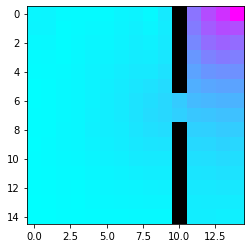

In [105]:
def linear_fqi(env, feat_map, num_iterations, lambd=0.1, gamma=0.95):
  """
  # Linear FQI implementation
  # TO BE COMPLETED
  """

  # get a dataset
  #    dataset = get_uniform_dataset(env, n_samples=...)
  # OR dataset = get_random_policy_dataset(env, n_samples=...)

  dataset = get_random_policy_dataset(env, n_samples = 10000)
  samples, actions, rewards, next_samples = dataset

  pos = {}
  for i in range(env.Na):
    pos[i] = np.where(actions == i)

  theta = np.zeros((feat_map.dim, env.Na))

  for it in range(num_iterations):
    for i in range(env.Na):
      phi = np.array([feat_map.map(samples[j]) for j in pos[i]])
      phi = np.squeeze(phi)
      yk = rewards[pos[i]] + gamma * np.max( feat_map.map(next_samples[pos[i]]).T @ theta, axis = 1) 
      theta[:, i] = np.linalg.inv(phi @ phi.T + lambd) @ np.sum(yk * phi, axis = 1)
  
  return theta

# ----------------------------
# Environment and feature map
# ----------------------------
env = get_large_gridworld()
# you can change the parameters of the feature map, and even try other maps!
feat_map = GridWorldFeatureMap(env, dim=100, sigma=0.25)

# -------
# Run FQI
# -------
theta = linear_fqi(env, feat_map, num_iterations=100, lambd=1)

# Compute and run greedy policy
Q_fqi = np.zeros((env.Ns, env.Na))
for ss in range(env.Ns):
  state_feat = feat_map.map(ss)
  Q_fqi[ss, :] = state_feat @ theta

V_fqi = Q_fqi.max(axis=1)
policy_fqi = Q_fqi.argmax(axis=1)
render_policy(env, policy_fqi, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V_fqi)    
plt.imshow(img)
plt.show()

In [106]:
Q, policy, Qfs = value_iteration(env.P, env.R, gamma = 0.95)

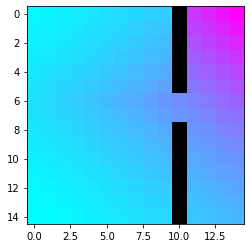

In [107]:
V = Q.max(axis=1)
render_policy(env, policy_fqi, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V)    
plt.imshow(img)
plt.show()

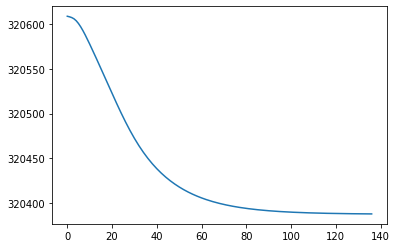

In [108]:
errors = [np.linalg.norm(Q_fqi - Qi) for Qi in Qfs]

plt.plot(errors)
plt.show()